In [29]:
import os
import pandas as pd
import numpy as np
import re

#Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20, 14.0)
import seaborn as sns
pd.options.mode.chained_assignment = None
from scipy.signal import argrelmin,argrelmax

We'll be starting with our run length data from the _classification_ folder. The data was developed from the _'Developing the Classification Table'_ notebook.

In [2]:
os.chdir('F:/classification')
#Read the first file
class_table=pd.read_csv(os.listdir()[0])

os.chdir('F:/CSV Data')
#Again, read the first file

def processData(game_id):
    motion=pd.read_csv("00"+str(game_id)+".csv",low_memory=False)
    motion=motion[motion.isnull().any(axis=1)==False].reset_index(drop=True)
    return(motion)

motion=processData(21500001)

In [3]:
#Look at passing data
passes=class_table[class_table["play"]=="PASS"]
pass_xy=np.vstack([motion[["ball_x","ball_y"]].values[p[0]:p[1]] for p in passes[["start","end"]].values])

__Simple visual of passes from a single game__

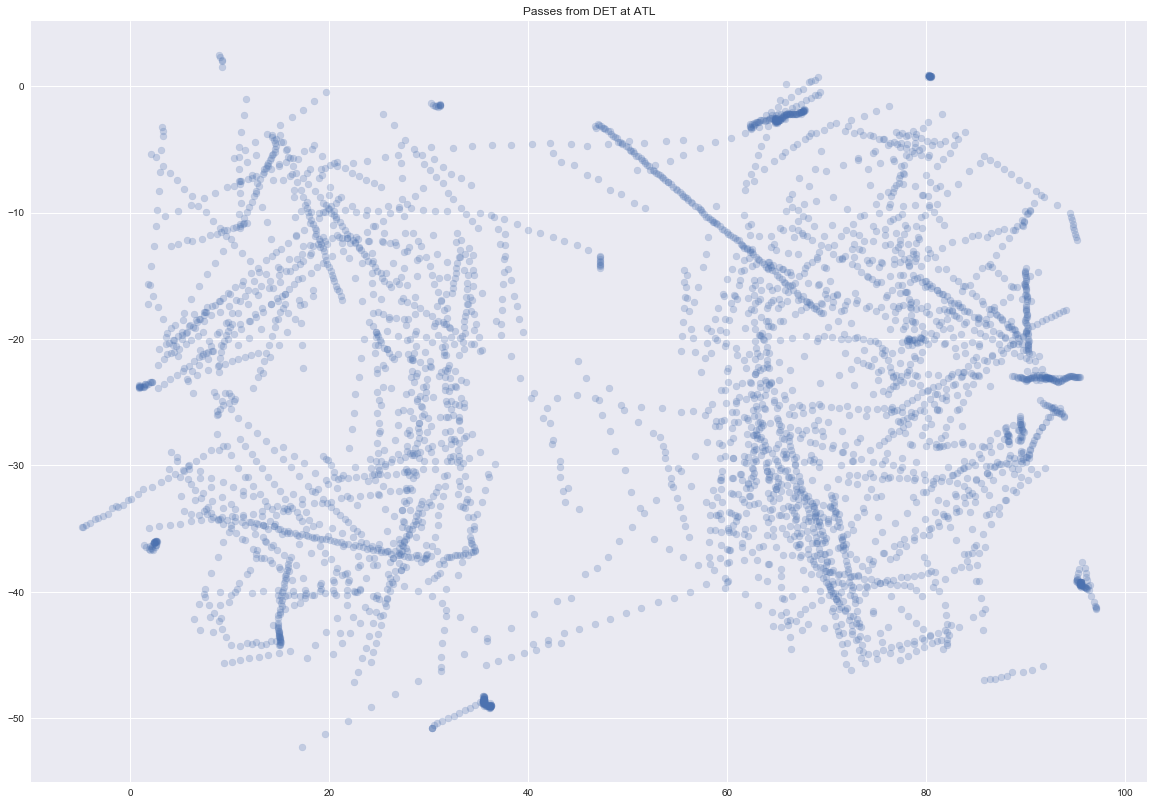

In [30]:
plt.scatter(pass_xy[:,0],-pass_xy[:,1],alpha=.25)
plt.title('Passes from DET at ATL')
plt.show()

# Gradient Algorithm

__Algorithm:__

Let the matrix of points (X-Y coordinates) at time $t$ be $P_{t}$.

Set the hoop coordinates as $p_{t,l}:=<5,25>,p_{t,r}:=<89,25>$ for all $t \in T$.

Let the ball coordinates be denoted as $p_{t,0}$

Let the players $i=1,...,10$ be defined as $p_{t,i}$

Let the __gradient__ of all non-hoop objects, $\nabla p_{t,i}$ for $i=0,...,10$

__Recall__ that a gradient is defined as: $$\nabla f(x,y) = \frac{\partial f}{\partial x} x + \frac{\partial f}{\partial y} y$$

For all $p_{t,i}$ for $i=0,...,10$, update our points based on their gradient $p^\star_{t,i}:=<x+w\frac{\partial f}{\partial x} x,y+w\frac{\partial f}{\partial y} y>$ Where $w$ is a scalar weight.

Find the Euclidean norm between the ball and all transformed points: $||p^\star_{t,0}-p^\star_{t,i}||$ for $i=1,...,10$, and also the hoops $||p^\star_{t,0}-p_{t,l}||,||p^\star_{t,0}-p_{t,r}||$. Denote this set of distances as $D^\star_{t}$

__Weak relationship__:

An object is said to be the _weak target_ of the ball at time $t$ if it has the smallest value within $D^\star_{t}$.

__Strong relationship__:

For $i=0,...,10$ draw the geometric lines: $$L_{i}=\{(x,y),(x+w_{1}\frac{\partial f}{\partial x} x, y+w_{2}\frac{\partial f}{\partial y} y)\}$$. For the hoops, draw circles $h_{l},h_{r}$ with radius $r$.

For $i=i,...,10$ Check to see if $L_{0} \cap L_{i}$ is true. Also check if $L_{0} \cap h_{l}$ or $L_{0} \cap h_{r}$ hold. For all objects that intersect $L_{0}$, find the Euclidean norm. The smallest value for all these objects is defined as the _strong target_ of the ball.

In [15]:
def makeXY(motion):
    #Set the X and Y values by adding ball, hoop coordinates
    ball_x_vals=motion.iloc[:,4].values.reshape(len(motion),1)
    player_x_vals=motion.iloc[:,8::3].values.reshape(len(motion),10)
    hoop_x_vals=np.repeat(np.array([5,89]).reshape(1,2),len(motion),axis=0)
    x_data=np.hstack((ball_x_vals,player_x_vals,hoop_x_vals))
    
    ball_y_vals=motion.iloc[:,5].values.reshape(len(motion),1)
    player_y_vals=motion.iloc[:,9::3].values.reshape(len(motion),10)
    hoop_y_vals=np.repeat(np.array([25,25]).reshape(1,2),len(motion),axis=0)
    y_data=np.hstack((ball_y_vals,player_y_vals,hoop_y_vals))
    
    xyz_array=np.dstack((x_data,y_data))
    return(xyz_array)

def makePlayerNames(motion,game_id):
    player_ids=motion.iloc[:,7::3]
    players=shots[shots.GAME_ID==game_id][["PLAYER_NAME","PLAYER_ID"]].drop_duplicates()
    player_dict=dict(zip(players.PLAYER_ID,players.PLAYER_NAME))
    player_names=[player_ids.iloc[:,i].map(player_dict).values for i in range(len(player_ids.columns))]
    player_names=pd.DataFrame(np.vstack(player_names).T,columns=player_ids.columns)
    player_names["lefthoop"]=pd.Series(["Left hoop"]*len(motion))
    player_names["righthoop"]=pd.Series(["Right hoop"]*len(motion))
    return(player_names)

def findTarget(data):
    try:
        return(np.argmax(pd.Series(data).value_counts()))
    except:
        return("None")

def gradientAlgorithm(motion,XY,player_names,pass_table,T,w):
    #Evaluate the gradient of XY:
    XYgrad=np.gradient(XY,axis=0)
    
    #Weight the gradient values
    XYstar=XY+w*XYgrad
    
    #Find the distances to the ball
    d_star=np.linalg.norm(XYstar-XYstar[:,0,:].reshape(len(motion),1,2),axis=2)
    
    #Find the closest object to the ball, based on gradient adjusted values
    d_min=d_star.argsort(axis=1)[:,1]-1
    min_df=pd.DataFrame(d_min,columns=["search"])
    
    #Create a dictionary to map numbers to column names and apply to the search.
    column_dict=dict(zip(np.arange(0,12),player_names.columns))
    min_df["search"]=min_df.search.map(column_dict)
    
    #Map the results from d_min to actual names
    weak_target=player_names.lookup(min_df.index,min_df.search.values)
    
    #Predict the label with findTarget
    pass_predictions=np.array([findTarget(weak_target[np.arange(t[0],t[1])]) for t in T])
    
    #Create a confusion matrix
    class_table=pd.crosstab(pass_table.p2,pass_predictions)
    
    #Generate an error rate and return it.
    error_rate=1-np.sum(np.diag(class_table))/len(pass_table)
    
    return(error_rate)

__Next steps:__

(1) Apply the algorithm to a random sample of games, perhaps a random subset of passes within each game.

(2) See how the algorithm works with shorther, longer passes.

__Sample the game id's__

In [58]:
shots=pd.read_csv('F:/ProjectTimDuncan/playershotsdf.csv')
os.chdir('F:/CSV Data')
game_ids=np.array([int(o.strip('.csv').lstrip('00')) for o in os.listdir()])
random_game_ids=np.random.choice(np.arange(0,len(game_ids)),30,replace=False)
random_games=game_ids[random_game_ids]

__Generalzing the Algorithm to run for any game__

In [32]:
def applyGradientAlgorithm(game_id,weights):
    #Read in the motion data
    os.chdir('F:/CSV Data')
    motion=processData(game_id)
    
    #Extract the XY values for each row in array form
    XY=makeXY(motion)
    
    #Read in the pass results, get start and end indices of passes
    os.chdir('F:/classification')
    class_table=pd.read_csv(str(game_id)+".csv")
    passes=class_table[class_table["play"]=="PASS"]
    pass_indices=passes[["start","end"]].values
    
    #Find the player names for a given game
    player_names=makePlayerNames(motion,game_id)
    
    #Apply the gradient algorithm
    gradient_errors=np.array([gradientAlgorithm(motion,XY,player_names,passes,pass_indices,w) for w in weights])
    
    return(gradient_errors)

In [61]:
game_gradient_error=applyGradientAlgorithm(21500002,np.arange(0,11))

In [62]:
game_gradient_error

array([ 0.86290323,  0.59677419,  0.52016129,  0.50403226,  0.46774194,
        0.45564516,  0.44354839,  0.43145161,  0.43145161,  0.4233871 ,
        0.42741935])

__Analyzing error rate for a single game__

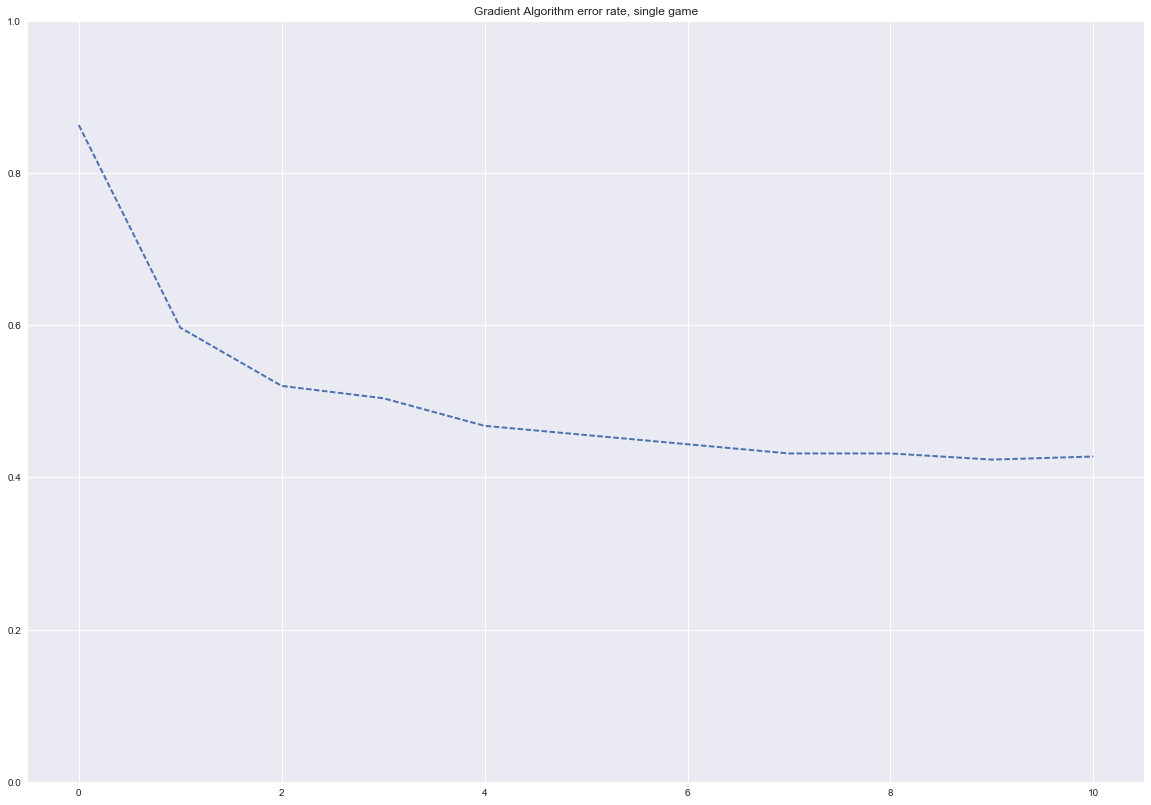

In [63]:
plt.plot(np.arange(0,11),game_gradient_error,'--',linewidth=2)
plt.ylim(0,1)
plt.title('Gradient Algorithm error rate, single game')
plt.show()

__Running the algorithm on multiple games, iterating from w=6:10__

In [64]:
game_errors_list=[applyGradientAlgorithm(gid,np.arange(6,11)) for gid in random_games]

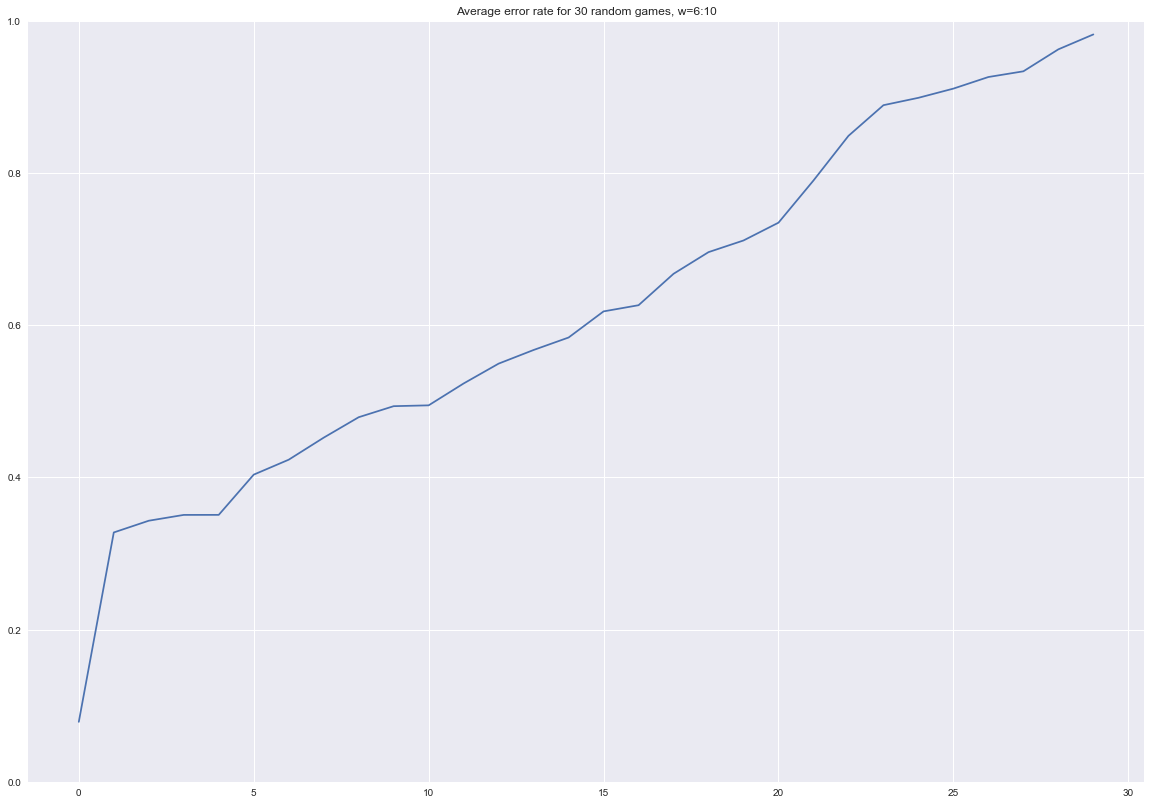

In [82]:
plt.plot(np.sort(np.vstack(game_errors_list).mean(axis=1)))
plt.ylim(0,1)
plt.title('Average error rate for 30 random games, w=6:10')
plt.show()